In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
# nlp = en_core_web_sm.load()
nlp = spacy.load('en_core_web_sm',  disable=["parser", "ner"])
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics.pairwise import pairwise_distances

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from imblearn.over_sampling import SMOTE


import xgboost as xgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.tokenize import word_tokenize
from collections import Counter
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import pickle

from pprint import pprint

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kous5\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kous5\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
pd.set_option('display.max_colwidth', 400)
pd.set_option("display.precision", 3)
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 60)

In [3]:
df = pd.read_csv("data_source/sample30.csv")

# EDA

In [4]:
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was ...",Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,Negative


In [5]:
df.shape

(30000, 15)

In [6]:
#checking all columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

## Data cleaning

In [7]:
#null check
count_for_null = df[df.columns[df.isna().any()]].isna().sum().sort_values(ascending=True)
percentage_of_null = (df[df.columns[df.isna().any()]].isna().sum() * 100 / df.shape[0]).sort_values(ascending=True)
check_data = pd.concat([percentage_of_null, count_for_null], axis=1, keys=[ 'Percentage', 'Count'])
check_data

,Percentage,Count
user_sentiment,0.003,1
reviews_date,0.153,46
reviews_username,0.210,63
manufacturer,0.470,141
reviews_title,0.633,190
reviews_doRecommend,8.567,2570
reviews_didPurchase,46.893,14068
reviews_userCity,93.570,28071
reviews_userProvince,99.433,29830


In [8]:
#having a working copy
df_wc = df.copy()

In [9]:
df_wc.drop(columns=['reviews_didPurchase','reviews_userProvince', 'reviews_userCity'], inplace=True)

In [10]:
# Checking NULLs again
count_for_null = df_wc[df_wc.columns[df_wc.isna().any()]].isna().sum().sort_values(ascending=True)
percentage_of_null = (df_wc[df_wc.columns[df_wc.isna().any()]].isna().sum() * 100 / df_wc.shape[0]).sort_values(ascending=True)
check_data = pd.concat([percentage_of_null, count_for_null], axis=1, keys=[ 'Percentage', 'Count'])
check_data

,Percentage,Count
user_sentiment,0.003,1
reviews_date,0.153,46
reviews_username,0.210,63
manufacturer,0.470,141
reviews_title,0.633,190
reviews_doRecommend,8.567,2570


### Checking `reviews_doRecommend` column


In [11]:
df_wc.reviews_doRecommend.value_counts(normalize=False)

True     25880
False     1550
Name: reviews_doRecommend, dtype: int64

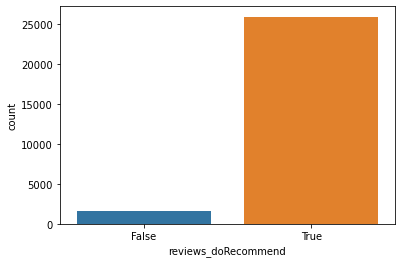

In [12]:
sns.countplot(x = 'reviews_doRecommend', data = df_wc)
plt.show()

In [13]:
#drop reviews_doRecommend as the variety of data in this column is least
df_wc.drop(columns=['reviews_doRecommend'], inplace=True)

In [14]:
# Checking NULLs again
count_for_null = df_wc[df_wc.columns[df_wc.isna().any()]].isna().sum().sort_values(ascending=True)
percentage_of_null = (df_wc[df_wc.columns[df_wc.isna().any()]].isna().sum() * 100 / df_wc.shape[0]).sort_values(ascending=True)
check_data = pd.concat([percentage_of_null, count_for_null], axis=1, keys=[ 'Percentage', 'Count'])
check_data

,Percentage,Count
user_sentiment,0.003,1
reviews_date,0.153,46
reviews_username,0.210,63
manufacturer,0.470,141
reviews_title,0.633,190


### NULL values in `reviews_title`

In [15]:
# Checking rowcount before deletion
df_wc.shape

(30000, 11)

In [16]:
df_wc = df_wc[~ df_wc.reviews_title.isna() ]

In [17]:
# Checking rowcount post deletion
df_wc.shape

(29810, 11)

In [18]:
# Checking NULLs again
count_for_null = df_wc[df_wc.columns[df_wc.isna().any()]].isna().sum().sort_values(ascending=True)
percentage_of_null = (df_wc[df_wc.columns[df_wc.isna().any()]].isna().sum() * 100 / df_wc.shape[0]).sort_values(ascending=True)
check_data = pd.concat([percentage_of_null, count_for_null], axis=1, keys=[ 'Percentage', 'Count'])
check_data

,Percentage,Count
user_sentiment,0.003,1
reviews_date,0.154,46
reviews_username,0.208,62
manufacturer,0.473,141


### NULL values in `reviews_username`

In [19]:
df_wc = df_wc[~ df_wc.reviews_username.isna() ]

In [20]:
# Checking rowcount post deletion
df_wc.shape

(29748, 11)

In [21]:
# Checking NULLs again
count_for_null = df_wc[df_wc.columns[df_wc.isna().any()]].isna().sum().sort_values(ascending=True)
percentage_of_null = (df_wc[df_wc.columns[df_wc.isna().any()]].isna().sum() * 100 / df_wc.shape[0]).sort_values(ascending=True)
check_data = pd.concat([percentage_of_null, count_for_null], axis=1, keys=[ 'Percentage', 'Count'])
check_data

,Percentage,Count
user_sentiment,0.003,1
reviews_date,0.134,40
manufacturer,0.474,141


### NULL values in `user_sentiment`

In [22]:
df_wc.user_sentiment.value_counts()

Positive    26412
Negative     3335
Name: user_sentiment, dtype: int64

In [23]:
df_wc[ df_wc.user_sentiment.isna() ]

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
28354,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Ways To Shop Entertainment,Movies & Tv On Blu-Ray,Movies & TV,Disney,Blu-ray,Children & Family,Movies & Music,Movies & TV Shows,Electronics, Tech Toys, Movies, Music,Blu-Rays,See ALL Blu-Ray,Frys",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),2014-11-07T00:00:00.000Z,5,my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the points towards our next rewards coupon we love the savings we get at Best Buy,a super hit with my children. they loved it!!??,7.87E+11,NaN


In [24]:
df_wc[ df_wc.user_sentiment.isna() ].user_sentiment

28354    NaN
Name: user_sentiment, dtype: object

In [25]:
df_wc.user_sentiment.fillna('Positive', inplace=True)

In [26]:
# Checking NULLs again
count_for_null = df_wc[df_wc.columns[df_wc.isna().any()]].isna().sum().sort_values(ascending=True)
percentage_of_null = (df_wc[df_wc.columns[df_wc.isna().any()]].isna().sum() * 100 / df_wc.shape[0]).sort_values(ascending=True)
check_data = pd.concat([percentage_of_null, count_for_null], axis=1, keys=[ 'Percentage', 'Count'])
check_data

,Percentage,Count
reviews_date,0.134,40
manufacturer,0.474,141


In [27]:
# Check the data for top 5 rows
df_wc.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was ...",Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,Negative


### Checking  `reviews_rating` column

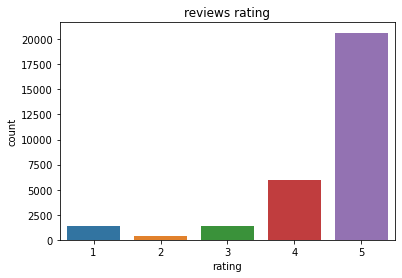

In [28]:
sns.countplot(x = 'reviews_rating', data = df_wc).set(title="reviews rating", xlabel="rating", ylabel="count")
plt.show()

### Checking for negative reviews

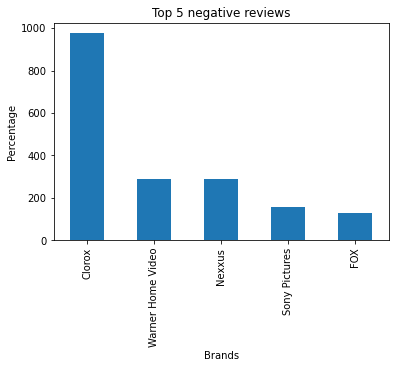

In [29]:
df_wc[ df_wc.user_sentiment == 'Negative' ].brand.value_counts(normalize=False, ascending=False).head().plot(kind='bar')
plt.title("Top 5 negative reviews")
plt.xlabel("Brands")
plt.ylabel("Percentage")
plt.show()

### Checking positive reviews

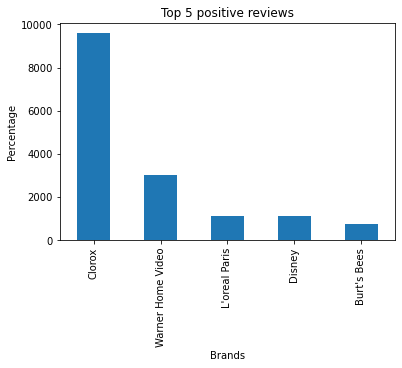

In [30]:
df_wc[ df_wc.user_sentiment == 'Positive' ].brand.value_counts(normalize=False, ascending=False).head().plot(kind='bar')
plt.title("Top 5 positive reviews")
plt.xlabel("Brands")
plt.ylabel("Percentage")
plt.show()

### Checking review counts based on year

In [31]:
df_wc['datetime'] = pd.to_datetime(df_wc['reviews_date'], errors='coerce')

In [32]:
# After type conversion
df_wc.datetime.dtype

datetime64[ns, UTC]

In [33]:
# Getting year component from date
df_wc.datetime.dt.year

0        2012.0
1        2017.0
2        2017.0
3        2016.0
4        2016.0
          ...  
29995    2017.0
29996    2017.0
29997    2017.0
29998    2017.0
29999    2017.0
Name: datetime, Length: 29748, dtype: float64

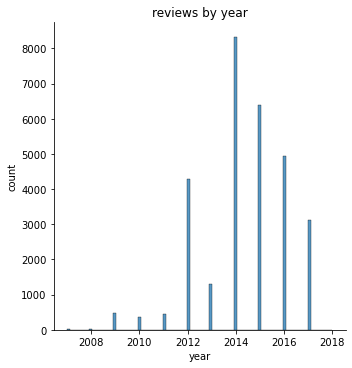

In [34]:
# Creating a distribution plot based on reviews year 
sns.displot(data=df_wc, x=df_wc.datetime.dt.year).set(title="reviews by year", xlabel="year", ylabel="count")
plt.show()

### Checking Movie Rating

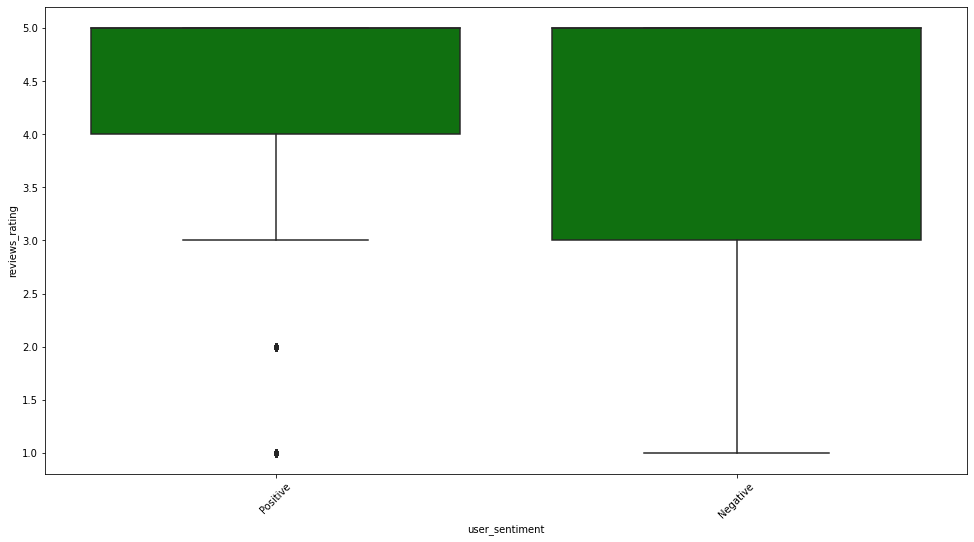

In [35]:
plt.figure(figsize = [15,9])

sns.boxplot(data=df_wc, x='user_sentiment', y='reviews_rating', color='green')
plt.xticks(rotation = 45)

plt.tight_layout(pad = 6)
plt.show()

In [36]:
df_wc[ (df_wc.user_sentiment == 'Negative') & (df_wc.reviews_rating >= 4) ].groupby(['reviews_rating']).count().user_sentiment

reviews_rating
4     548
5    1848
Name: user_sentiment, dtype: int64

# Conversion

In [37]:
# Convert all the text columns to string

df_wc['reviews_title'] = df_wc['reviews_title'].astype(str)
df_wc['reviews_text'] = df_wc['reviews_text'].astype(str)
df_wc['reviews_username'] = df_wc['reviews_username'].astype(str)
df_wc['brand'] = df_wc['brand'].astype(str)
df_wc['manufacturer'] = df_wc['manufacturer'].astype(str)
df_wc['name'] = df_wc['name'].astype(str)
df_wc['categories'] = df_wc['categories'].astype(str)

# Pre-Processing

In [38]:
# Getting a copy of dataframe for pre-processing
df_new_copy = df_wc.copy()

## Combining columns

In [39]:
df_new_copy['reviews_combined'] = df_new_copy['reviews_text'] + " " + df_new_copy['reviews_title']
df_new_copy.drop(columns=['reviews_text', 'reviews_title'], inplace=True)

In [40]:
df_new_copy.shape

(29748, 11)

## Removing extra columns

In [41]:
df_new_copy.drop(columns=[ 'datetime', 'manufacturer', 'categories'], inplace=True)

## Creating new dataframe

In [42]:
#df for sentiment analysis
df_sentiment_analysis = df_new_copy[['id','name', 'user_sentiment', 'reviews_combined']]

In [43]:
df_sentiment_analysis.shape

(29748, 4)

## Handling punctuations

In [44]:
# removing punctuations
def removing_punctuations(sentence):
    sentence = sentence.lower()
    regex_pattern = '[^\w\s]'
    sentence = re.sub(regex_pattern, '', sentence)
    return sentence

In [45]:
df_sentiment_analysis['reviews_cleaned'] = df_sentiment_analysis['reviews_combined'].apply(removing_punctuations)

## Stopwords removal

In [46]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kous5\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [47]:
from nltk.corpus import stopwords
stopwords_list = set(stopwords.words("english"))
print(stopwords_list)

{"wouldn't", 'do', 'that', 'does', 'only', 'between', 'couldn', 'few', 'why', "won't", 'his', 'for', 'your', 'you', 'there', 'myself', 'just', 'these', "isn't", 'above', 'further', 'once', 'again', 'all', "should've", 'down', 'but', 'did', 'a', 'her', 'before', 'into', 'this', 'what', 'more', "that'll", 'other', 'm', "needn't", "you'll", 'needn', 's', 'who', 'wouldn', 'no', 'ma', 'didn', 'than', 'through', 'those', 'itself', 'we', 'they', 'weren', 'has', 'y', "hadn't", 'doing', "you've", 'should', "don't", 'while', 'isn', 'me', 'having', 'doesn', 'their', 'was', 'off', 'from', 'were', 'my', 'himself', "hasn't", 'then', 'when', 'o', 're', 'an', "wasn't", 'not', 'had', 'yours', 'our', 'in', 'and', 'most', 'too', 'during', 'each', "shouldn't", 'been', "doesn't", 'yourselves', 'mightn', "shan't", 'hadn', 'aren', 'here', 'yourself', 'on', 'have', 'so', 'd', 'shan', 'by', 'wasn', 'about', 'now', 'won', 'nor', 'any', 'or', 'she', 'shouldn', "mightn't", "mustn't", 'he', 'at', 'some', 'same', '

In [48]:
# stopwords removal
def removing_stopwords(sentence):
    sentence = sentence.lower()
    words = word_tokenize(sentence)
    text_nostopwords = " ".join( [word for word in words if word not in stopwords_list] )
    return sentence

In [49]:
df_sentiment_analysis['reviews_cleaned'] = df_sentiment_analysis['reviews_cleaned'].apply(removing_stopwords)

## Lemmatization

In [50]:
#Lemmatizing the text
def removing_lemma(received_text):
    sentence = []
    document = nlp(received_text)
    for token in document:
        sentence.append(token.lemma_)
    return " ".join(sentence)

In [51]:
df_sentiment_analysis['reviews_lemmatized'] = df_sentiment_analysis['reviews_cleaned'].apply(removing_lemma)

In [52]:
df_sentiment_analysis = df_sentiment_analysis[['id','name', 'user_sentiment', 'reviews_lemmatized']]

In [53]:
df_sentiment_analysis.shape

(29748, 4)

In [54]:
# Saving the the cleaned dataframe
pickle.dump(df_sentiment_analysis, open("./models/clean_data.pkl","wb"))

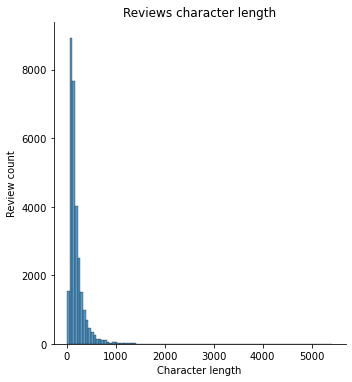

In [55]:
# Visualizing 'reviews_lemmatized' character length
length_of_character = [len(sentence) for sentence in df_sentiment_analysis['reviews_lemmatized']]

sns.displot(length_of_character, kind='hist', bins=100)
plt.xlabel("Character length")
plt.ylabel("Review count")
plt.title("Reviews character length")
plt.show()

## TF-IDF

In [56]:
#TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5, max_df=0.95, stop_words='english', ngram_range=(1,2))

In [57]:
X = tfidf.fit_transform(df_sentiment_analysis['reviews_lemmatized'])

y= df_sentiment_analysis['user_sentiment']

In [58]:
# Saving the the tfidf vectorizer model
pickle.dump(tfidf, open("./models/tfidf.pkl","wb"))

## Train, test split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [60]:
print("Training data shape:", X_train.shape, y_train.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Training data shape: (22311, 16073) (22311,)
Test data shape: (7437, 16073) (7437,)


## Class Imbalance

In [61]:
# Check for imbalance
df_sentiment_analysis['user_sentiment'].value_counts(normalize=False)

Positive    26413
Negative     3335
Name: user_sentiment, dtype: int64

In [62]:
counter = Counter(y_train)
print("Without handling imbalance", counter)

#oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train,y_train)

counter = Counter(y_train_sm)
print("With handling imbalance", counter)

Without handling imbalance Counter({'Positive': 19786, 'Negative': 2525})
With handling imbalance Counter({'Positive': 19786, 'Negative': 19786})


# Building the model

In [63]:
# displaying scores
def score_calculation(classifier, X_test, y_test):

  y_pred = classifier.predict(X_test)
  conf_m = confusion_matrix(y_test, y_pred)
  print("Confusion Matrix ")
  fig, ax = plt.subplots(figsize=(6, 6))
  ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                  annot=True,
                  cbar=False,
                  cmap="RdYlGn", fmt = '0.1f')
  plt.xlabel("Actual")
  plt.ylabel("Predicted")
  plt.show()

  # Calculating the values of True Positives, True Negatives, False Positivies and False Negatives
  TP = conf_m[1][1]
  TN = conf_m[0][0]
  FP = conf_m[0][1]
  FN = conf_m[1][0]

  print('True Positives:', TP)
  print('True Negatives:', TN)
  print('False Positives:', FP)
  print('False Negatives:', FN)
  print("\n")

  accuracy_value = accuracy_score(y_test, y_pred)
  accuracy = round(accuracy_value,3)
  
  sensitivity_score = (TP / float(TP + FN))
  sensitivity = round(sensitivity_score,3)
  
  specificity_score = (TN / float(TN + FP))
  specificity = round(specificity_score,3)  
  
  precision_score = (TN / float(TN + FP))
  precision = round(precision_score,3)  
  
  F1_score = 2 * ((precision * sensitivity) / (precision + sensitivity))
  F1_score = round(F1_score,3)  
  
  print(f'Accuracy Score: {accuracy}')
  print(f'Sensitivity Score: {sensitivity}') 
  print(f'Specificity Score: {specificity}') 
  print(f'Precision: {precision}')
  print(f'F1 Score: {F1_score}')

  evaluation_metrics = []
  evaluation_metrics.append(accuracy)
  evaluation_metrics.append(sensitivity)
  evaluation_metrics.append(specificity)
  evaluation_metrics.append(precision)
  evaluation_metrics.append(F1_score)
  
  return evaluation_metrics

## Logistic Regression

In [64]:
regressor = LogisticRegression(random_state=42, solver='liblinear').fit(X_train_sm, y_train_sm)

Confusion Matrix 


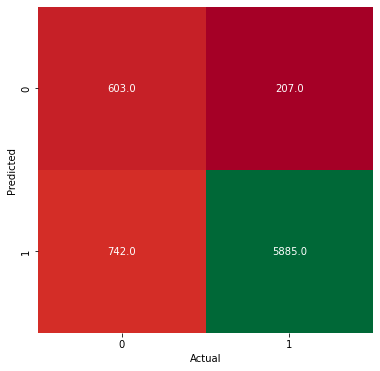

True Positives: 5885
True Negatives: 603
False Positives: 207
False Negatives: 742


Accuracy Score: 0.872
Sensitivity Score: 0.888
Specificity Score: 0.744
Precision: 0.744
F1 Score: 0.81


In [65]:
logistic_regression_metrics = score_calculation(regressor, X_test, y_test)

In [66]:
# Printing the scores of the base model as reference
df_logrermat = pd.DataFrame({'Metrics': ['Accuracy','Sensitivity','Specificity','Precision','F1 Score'], 'Base Model': logistic_regression_metrics},
                             columns = ['Metrics', 'Base Model']
                             )
df_logrermat

,Metrics,Base Model
0,Accuracy,0.872
1,Sensitivity,0.888
2,Specificity,0.744
3,Precision,0.744
4,F1 Score,0.810


### HyperParameter Tuning

In [67]:
logisticRegressor_grid = {"C": [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],
                "solver": ["liblinear"]}

In [68]:
logisticRegressor_hyperparameter_tuning = GridSearchCV(LogisticRegression(random_state=42),
                                param_grid=logisticRegressor_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

logisticRegressor_hyperparameter_tuning.fit(X_train_sm, y_train_sm);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [69]:
logisticRegressor_hyperparameter_tuning.best_params_

{'C': 100, 'solver': 'liblinear'}

### HyperParameter Tuned Model

Confusion Matrix 


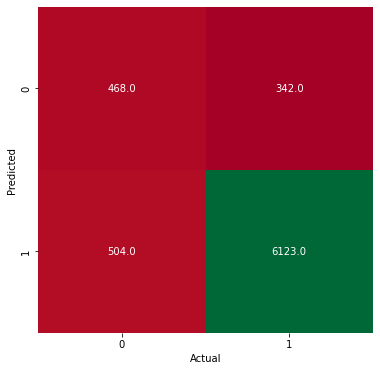

True Positives: 6123
True Negatives: 468
False Positives: 342
False Negatives: 504


Accuracy Score: 0.886
Sensitivity Score: 0.924
Specificity Score: 0.578
Precision: 0.578
F1 Score: 0.711


In [70]:
# Getting the scores of the tuned model
logisticRegressor_tuned_metrics = score_calculation(logisticRegressor_hyperparameter_tuning, X_test, y_test)

In [71]:
# Printing the scores of the base and tuned Logistic Regression model for reference
dict_logisticRegressor_basetuned_metrics = {'Metrics': ['Accuracy','Sensitivity','Specificity','Precision','F1 Score'], 
                               'LR Base Model': logistic_regression_metrics,
                               'LR Tuned Model': logisticRegressor_tuned_metrics}

df_logisticRegressor_basetuned_metrics = pd.DataFrame(dict_logisticRegressor_basetuned_metrics, columns = ['Metrics', 'LR Base Model', 'LR Tuned Model'])
df_logisticRegressor_basetuned_metrics

,Metrics,LR Base Model,LR Tuned Model
0,Accuracy,0.872,0.886
1,Sensitivity,0.888,0.924
2,Specificity,0.744,0.578
3,Precision,0.744,0.578
4,F1 Score,0.810,0.711


In [72]:
lr_base_model = pickle.dump(regressor, open('./pickle/lr_base_model.pkl', 'wb'))

In [73]:
lr_tuned_model = pickle.dump(logisticRegressor_hyperparameter_tuning, open('./pickle/lr_tuned_model.pkl', 'wb'))

## Random Forest Classifier

In [74]:
randomforest = RandomForestClassifier(random_state=42).fit(X_train_sm, y_train_sm)

### Base Model

Confusion Matrix 


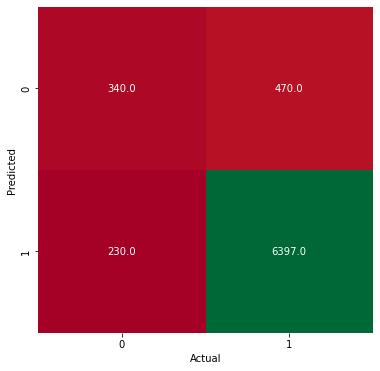

True Positives: 6397
True Negatives: 340
False Positives: 470
False Negatives: 230


Accuracy Score: 0.906
Sensitivity Score: 0.965
Specificity Score: 0.42
Precision: 0.42
F1 Score: 0.585


In [75]:
# Getting the score of the base model
randomforest_metrics = score_calculation(randomforest, X_test, y_test)

In [76]:
# Printing the scores of the base model as reference
df_randomforest_base_metrics = pd.DataFrame({'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 'RF Base Model': randomforest_metrics},
                             columns = ['Metrics', 'RF Base Model']
                             )
df_randomforest_base_metrics

,Metrics,RF Base Model
0,Accuracy,0.906
1,Sensitivity/Recall,0.965
2,Specificity,0.420
3,Precision,0.420
4,F1 Score,0.585


### HyperParameter Tuning

In [77]:
randomforest_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": np.arange(10, 50, 5),
           "min_samples_split": np.arange(15, 500, 15),
           "min_samples_leaf": np.arange(5, 50, 5)}

In [78]:
# Setup random hyperparameter search for Random Forest Classifier
randomforest_hyperparametertune = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                param_distributions=randomforest_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
randomforest_hyperparametertune.fit(X_train_sm, y_train_sm);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [79]:
# Check best parameters
randomforest_hyperparametertune.best_params_

{'n_estimators': 310,
 'min_samples_split': 180,
 'min_samples_leaf': 20,
 'max_depth': 15}

Confusion Matrix 


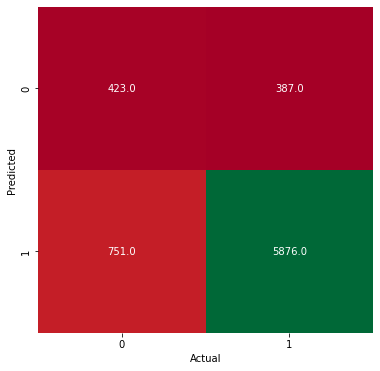

True Positives: 5876
True Negatives: 423
False Positives: 387
False Negatives: 751


Accuracy Score: 0.847
Sensitivity Score: 0.887
Specificity Score: 0.522
Precision: 0.522
F1 Score: 0.657


[0.847, 0.887, 0.522, 0.522, 0.657]

In [80]:
score_calculation(randomforest_hyperparametertune, X_test, y_test)

In [81]:
# Fine tuning using Grid Search CV
randomforest_grid = {"n_estimators": [510],
           "max_depth": [20],
           "min_samples_split": [350, 400],
           "min_samples_leaf": [45, 50]}

In [82]:
# Setup random hyperparameter search for Random Forest Classifier
randomforest_hyperparametertune = GridSearchCV(RandomForestClassifier(random_state=42),
                                param_grid=randomforest_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
randomforest_hyperparametertune.fit(X_train_sm, y_train_sm);

Fitting 5 folds for each of 4 candidates, totalling 20 fits


### HyperParameter tuned model

Confusion Matrix 


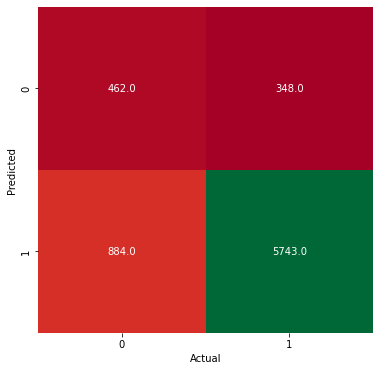

True Positives: 5743
True Negatives: 462
False Positives: 348
False Negatives: 884


Accuracy Score: 0.834
Sensitivity Score: 0.867
Specificity Score: 0.57
Precision: 0.57
F1 Score: 0.688


In [83]:
# Getting the scores of the tuned model
randomforest_tuned_metrics = score_calculation(randomforest_hyperparametertune, X_test, y_test)

In [84]:
# Printing the scores of the base and tuned Random Forest model as reference
dict_randomforest_basetuned_metrics = {'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 
                               'RF Base Model': randomforest_metrics,
                               'RF Tuned Model': randomforest_tuned_metrics}

df_randomforest_basetuned_metrics = pd.DataFrame(dict_randomforest_basetuned_metrics, columns = ['Metrics', 'RF Base Model', 'RF Tuned Model'])
df_randomforest_basetuned_metrics

,Metrics,RF Base Model,RF Tuned Model
0,Accuracy,0.906,0.834
1,Sensitivity/Recall,0.965,0.867
2,Specificity,0.420,0.570
3,Precision,0.420,0.570
4,F1 Score,0.585,0.688


In [85]:
rf_base_model = pickle.dump(randomforest, open('./pickle/rf_base_model.pkl', 'wb'))

In [86]:
rf_tuned_model = pickle.dump(randomforest_hyperparametertune, open('./pickle/rf_tuned_model.pkl', 'wb'))

## XGBoost Classifier

In [87]:
xg = xgb.XGBClassifier(random_state=42).fit(X_train_sm, y_train_sm)

[21:09:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Confusion Matrix 


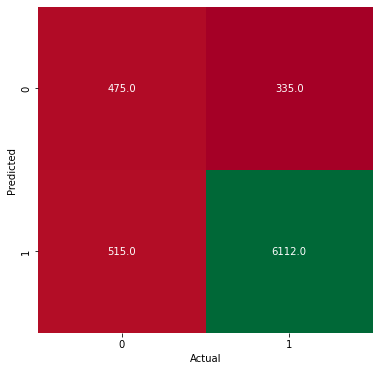

True Positives: 6112
True Negatives: 475
False Positives: 335
False Negatives: 515


Accuracy Score: 0.886
Sensitivity Score: 0.922
Specificity Score: 0.586
Precision: 0.586
F1 Score: 0.717


In [88]:
# Getting the score of the base model
xg_metrics = score_calculation(xg, X_test, y_test)

In [89]:
# Printing the scores of the base model as reference
df_xgboost_metrics = pd.DataFrame({'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 'XG Base Model': xg_metrics},
                             columns = ['Metrics', 'XG Base Model']
                             )
df_xgboost_metrics

,Metrics,XG Base Model
0,Accuracy,0.886
1,Sensitivity/Recall,0.922
2,Specificity,0.586
3,Precision,0.586
4,F1 Score,0.717


### HyperParameter Tuning

In [90]:
xgboost_grid = {"learning_rate": np.arange(0.05, 1, 0.1),
           "max_depth": np.arange(5, 20, 5)
           }

In [91]:
# Setup random hyperparameter search for Random Forest Classifier
xgboost_hyperparametertune = RandomizedSearchCV(XGBClassifier(random_state=42),
                                param_distributions=xgboost_grid,
                                cv=4,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
xgboost_hyperparametertune.fit(X_train_sm, y_train_sm);

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[21:20:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [92]:
# Check best parameters
xgboost_hyperparametertune.best_params_

{'max_depth': 10, 'learning_rate': 0.05}

Confusion Matrix 


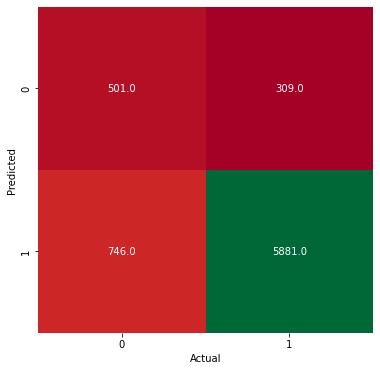

True Positives: 5881
True Negatives: 501
False Positives: 309
False Negatives: 746


Accuracy Score: 0.858
Sensitivity Score: 0.887
Specificity Score: 0.619
Precision: 0.619
F1 Score: 0.729


[0.858, 0.887, 0.619, 0.619, 0.729]

In [93]:
score_calculation(xgboost_hyperparametertune, X_test, y_test)

In [94]:
# Fine tuning with Grid Search CV
xgboost_grid = {"learning_rate": [0.45, 0.15],
           "max_depth": [5, 10]
           }

In [95]:
xgboost_hyperparametertune = GridSearchCV(XGBClassifier(random_state=42),
                                param_grid=xgboost_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

xgboost_hyperparametertune.fit(X_train_sm, y_train_sm);

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[21:23:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [96]:
# Check best parameters
xgboost_hyperparametertune.best_params_

{'learning_rate': 0.45, 'max_depth': 5}

### HyperParameter tuned model

Confusion Matrix 


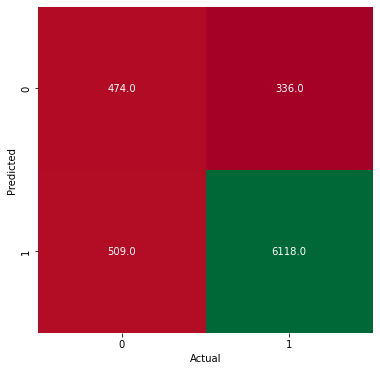

True Positives: 6118
True Negatives: 474
False Positives: 336
False Negatives: 509


Accuracy Score: 0.886
Sensitivity Score: 0.923
Specificity Score: 0.585
Precision: 0.585
F1 Score: 0.716


In [97]:
# Getting the scores of the tuned model
xgboost_tuned_metrics = score_calculation(xgboost_hyperparametertune, X_test, y_test)

In [98]:
# Printing the scores of the base and tuned XGBoost model as reference
dict_xgboost_basetuned_metrics = {'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 
                               'XG Base Model': xg_metrics,
                               'XG Tuned Model': xgboost_tuned_metrics}

df_xgboost_basetuned_metrics = pd.DataFrame(dict_xgboost_basetuned_metrics, columns = ['Metrics', 'XG Base Model', 'XG Tuned Model'])
df_xgboost_basetuned_metrics

,Metrics,XG Base Model,XG Tuned Model
0,Accuracy,0.886,0.886
1,Sensitivity/Recall,0.922,0.923
2,Specificity,0.586,0.585
3,Precision,0.586,0.585
4,F1 Score,0.717,0.716


In [99]:
xg_base_model = pickle.dump(xg, open('./pickle/xg_base_model.pkl', 'wb'))

In [100]:
xg_tuned_model = pickle.dump(xgboost_hyperparametertune, open('./pickle/xg_tuned_model.pkl', 'wb'))

# Model Evaluation

In [101]:
# Printing the scores of all the 3 Models (Base and Tuned)
dict_basetuned_metrics = {'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'],
                              'LR Base Model': logistic_regression_metrics, 'LR Tuned Model': logisticRegressor_tuned_metrics,
                              'RF Base Model': randomforest_metrics, 'RF Tuned Model': randomforest_tuned_metrics,
                              'XG Base Model': xg_metrics, 'XG Tuned Model': xgboost_tuned_metrics}

df_basetuned_metrics = pd.DataFrame(dict_basetuned_metrics, columns = ['Metrics', 'LR Base Model', 'LR Tuned Model', 'RF Base Model', 'RF Tuned Model', 'XG Base Model', 'XG Tuned Model'])
df_basetuned_metrics

,Metrics,LR Base Model,LR Tuned Model,RF Base Model,RF Tuned Model,XG Base Model,XG Tuned Model
0,Accuracy,0.872,0.886,0.906,0.834,0.886,0.886
1,Sensitivity/Recall,0.888,0.924,0.965,0.867,0.922,0.923
2,Specificity,0.744,0.578,0.420,0.570,0.586,0.585
3,Precision,0.744,0.578,0.420,0.570,0.586,0.585
4,F1 Score,0.810,0.711,0.585,0.688,0.717,0.716


In [102]:
best_sentiment_model = pickle.dump(regressor, open('./models/best_sentiment_model.pkl', 'wb'))

## Import data

In [105]:
df_recommended = pd.read_csv("data_source/sample30.csv")

In [106]:
df_recommended.shape

(30000, 15)

In [107]:
# We need only the below columns for building a recommendation system
df_recommended = df_recommended[["id", "name", "reviews_rating", "reviews_username"]]

## Handling NULL values

In [108]:
# Getting total number of NULL values and percentage of the columns
count_for_null = df_recommended[df_recommended.columns[df_recommended.isna().any()]].isna().sum().sort_values(ascending=True)
percentage_of_null = (df_recommended[df_recommended.columns[df_recommended.isna().any()]].isna().sum() * 100 / df_recommended.shape[0]).sort_values(ascending=True)
check_data = pd.concat([percentage_of_null, count_for_null ], axis=1, keys=['Percentage', 'Count' ])
check_data

,Percentage,Count
reviews_username,0.21,63


In [109]:
# Removing the rows where reviews_username is NULL
df_recommended = df_recommended[~ df_recommended.reviews_username.isna() ]

In [110]:
df_recommended.shape

(29937, 4)

In [111]:
# Check if any NULL values still exist in the dataset
count_for_null = df_recommended[df_recommended.columns[df_recommended.isna().any()]].isna().sum().sort_values(ascending=True)
percentage_of_null = (df_recommended[df_recommended.columns[df_recommended.isna().any()]].isna().sum() * 100 / df_recommended.shape[0]).sort_values(ascending=True)
check_data = pd.concat([percentage_of_null, count_for_null], axis=1, keys=['Percentage', 'Count' ])
check_data

,Percentage,Count


## Train, Test Split

In [112]:
train, test = train_test_split(df_recommended, test_size=0.30, random_state=42)

In [113]:
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(0)

In [114]:
# Copy the train dataset into dummy_train
train_dummy = train.copy()

In [115]:
# The products not rated by user is marked as 1 for prediction. 
train_dummy['reviews_rating'] = train_dummy['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [116]:
# Convert the dummy train dataset into matrix format
train_dummy = train_dummy.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(1)

train_dummy.head(3)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,...,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [117]:
# Pivot the train ratings' dataset into matrix format in which columns are Products and the rows are usernames.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
)

In [118]:
# For verification purpose, we do have cases where the rating is not NaN
df_pivot[~df_pivot['AV13O1A8GV-KLJ3akUyj'].isna()]

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,...,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
joshua,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Normalising the rating of the product for each user around 0 mean

In [119]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [120]:
df_subtracted.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,...,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Finding cosine similarity

In [121]:
user_corr = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_corr[np.isnan(user_corr)] = 0
print(user_corr)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [122]:
user_corr.shape

(18275, 18275)

## Prediction - User User

In [123]:
user_corr[user_corr<0]=0
user_corr

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [124]:
user_predicted_ratings = np.dot(user_corr, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 2.5       , ..., 1.46525748, 1.88982237,
        0.20412415],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [125]:
user_predicted_ratings.shape

(18275, 256)

In [126]:
user_final_rating = np.multiply(user_predicted_ratings,train_dummy)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,...,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,2.5,3.596,0.0,0.0,0.0,0.0,2.582,1.018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.623,0.0,2.5,0.0,0.0,0.645,1.667,0.189,0.0,0.0,0.0,0.0,0.0,1.465,1.89,0.204
01impala,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.000
02dakota,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.000
02deuce,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.000
0325home,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.000


## Finding the Top 20 products that a user is most likely to purchase based on the ratings

In [127]:
# Take a sample username as input.
user_input = '00sab00'

In [128]:
top20_reco = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
df_top20_reco = pd.DataFrame({'Product Id': top20_reco.index, 'cosine_similarity_score' : top20_reco})
df_top20_reco.reset_index(drop=True, inplace=True)
df_top20_reco

,Product Id,cosine_similarity_score
0,AVpfPaoqLJeJML435Xk9,37.473
1,AVpfRTh1ilAPnD_xYic2,29.191
2,AVpf0eb2LJeJML43EVSt,14.259
3,AVpf3VOfilAPnD_xjpun,12.314
4,AVpf2tw1ilAPnD_xjflC,11.178
5,AVpfBrUZilAPnD_xTUly,7.832
6,AVpfov9TLJeJML43A7B0,6.623
7,AVpf385g1cnluZ0-s0_t,6.254
8,AVpfM_ytilAPnD_xXIJb,6.155
9,AVpfR5m0LJeJML436K3W,5.651


In [129]:
top20_rec = pd.merge(df_recommended, df_top20_reco,left_on='id',right_on='Product Id', how = 'inner')[['Product Id', 'name', 'cosine_similarity_score']].drop_duplicates()
top20_rec.reset_index(drop=True, inplace=True)
top20_rec.sort_values(by='cosine_similarity_score', ascending=False)

,Product Id,name,cosine_similarity_score
16,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,37.473
19,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),29.191
2,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),14.259
6,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,12.314
4,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),11.178
9,AVpfBrUZilAPnD_xTUly,"Coty Airspun Face Powder, Translucent Extra Coverage",7.832
15,AVpfov9TLJeJML43A7B0,Bisquick Original Pancake And Baking Mix - 40oz,6.623
5,AVpf385g1cnluZ0-s0_t,"Hormel Chili, No Beans",6.254
11,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,6.155
18,AVpfR5m0LJeJML436K3W,Jason Aldean - They Don't Know,5.651


In [130]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(2051, 4)

In [131]:
common.head(2)

,id,name,reviews_rating,reviews_username
12875,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,jessica
21657,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,romance318


In [132]:
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [133]:
common_user_based_matrix.head(2)

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,...,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfi79RLJeJML43_Jo0,AVpfiUrfLJeJML43-9nY,AVpfk4y7ilAPnD_xeTgd,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmjXGLJeJML43AQ5_,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_corr)

In [135]:
user_correlation_df.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,...,18245,18246,18247,18248,18249,18250,18251,18252,18253,18254,18255,18256,18257,18258,18259,18260,18261,18262,18263,18264,18265,18266,18267,18268,18269,18270,18271,18272,18273,18274
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
df_subtracted.head(1)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,...,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
user_correlation_df['userId'] = df_subtracted.index
user_correlation_df.set_index('userId',inplace=True)
user_correlation_df.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,...,18245,18246,18247,18248,18249,18250,18251,18252,18253,18254,18255,18256,18257,18258,18259,18260,18261,18262,18263,18264,18265,18266,18267,18268,18269,18270,18271,18272,18273,18274
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [138]:
common.head(1)

,id,name,reviews_rating,reviews_username
12875,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,jessica


In [139]:
common_name = common.reviews_username.tolist()

user_correlation_df.columns = df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(common_name)]

In [140]:
user_correlation_df_1.shape

(1693, 18275)

In [141]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(common_name)]

In [142]:
user_correlation_df_3 = user_correlation_df_2.T

In [143]:
user_correlation_df_3.head()

,1234,1234567,123charlie,1943,1witch,4 rooms 1 dog lotsa fur,85lisa,a hutch,aac06002,aalyah,aaron,abcgator,abismomy,abret,ac94,acg1,acjuarez08,aclass,adam,adizzione,adma2,adriana9999,ael26,afooey,afwifey2003,agmt,ah78,aj,aj1135,ajay,...,voxemluth,wackibanan,wally,watson28,wcgirl,wendy,wernigcourtney,weston t,wildchild23,wildman,willy,wimbly,wjb1,wolfie,wolverine,wonster67,woody,woowoo,wowiezowie,wren113,xavier,yamel97,yayawomack,yorkielvr,yummy,yvonne,zach,zebras,zippy,zxcsdfd
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
user_correlation_df_3.shape

(1693, 1693)

In [145]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [146]:
common.head(2)

,id,name,reviews_rating,reviews_username
12875,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,jessica
21657,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,romance318


In [147]:
# Creating dummy test dataframe
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)

In [148]:
dummy_test.shape

(1693, 140)

In [149]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [150]:
common_user_predicted_ratings.head(2)

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,...,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfi79RLJeJML43_Jo0,AVpfiUrfLJeJML43-9nY,AVpfk4y7ilAPnD_xeTgd,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmjXGLJeJML43AQ5_,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [151]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [152]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [153]:
# Finding total non-NaN value
total_non_NaN = np.count_nonzero(~np.isnan(y))

RMSE (Root Mean Square Error) for User-User recommendation system

In [154]:
rmse_user_user = (sum(sum((common_ - y )**2))/total_non_NaN)**0.5
print(rmse_user_user)

2.551419404666111


## Using Item Similarity

In [155]:
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).T

In [156]:
df_pivot.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1234,1234561,1234567,1234asdf,123cat123,123charlie,123numbers,123rs,123too,127726,12cass12,12gage,132457,13dani,13ram,13thfaerie,1421nikki,143st,...,zmom,znxfyt,zod10,zodness,zoe1988,zoeellasca,zoeyny,zombie,zombiedad80,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zookeeper,zoso60,zotox,zowie,zozo0o,zpalma,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [157]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [158]:
df_subtracted.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1234,1234561,1234567,1234asdf,123cat123,123charlie,123numbers,123rs,123too,127726,12cass12,12gage,132457,13dani,13ram,13thfaerie,1421nikki,143st,...,zmom,znxfyt,zod10,zodness,zoe1988,zoeellasca,zoeyny,zombie,zombiedad80,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zookeeper,zoso60,zotox,zowie,zozo0o,zpalma,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [159]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [160]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

## Prediction - Item Item

In [161]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.00603917, 0.06485571,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0094556 ],
       [0.        , 0.        , 0.        , ..., 0.00781596, 0.10809285,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00756448]])

In [162]:
item_predicted_ratings.shape

(18275, 256)

In [163]:
train_dummy.shape

(18275, 256)

### Filtering the rating only for the products not rated by the user for recommendation

In [164]:
item_final_rating = np.multiply(item_predicted_ratings,train_dummy)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,...,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,6.042e-03,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000e+00,0.008,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.016,0.005,0.0,0.000,0.0,0.0,0.01,0.0,0.000,0.0,0.0,0.0,0.0,0.021,0.006,0.065,0.000
01impala,0.0,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,9.045e-04,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.003,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.003,0.0,0.005,0.0,0.0,0.00,0.0,0.098,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000
02dakota,0.0,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,1.508e-03,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.002,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.005,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.005,0.0,0.009,0.0,0.0,0.00,0.0,0.163,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000
02deuce,0.0,0.0,0.0,0.000e+00,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,1.206e-03,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.004,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.004,0.0,0.007,0.0,0.0,0.00,0.0,0.130,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000
0325home,0.0,0.0,0.0,8.222e-05,0.0,0.0,0.0,0.001,0.002,0.002,0.0,0.0,0.0,0.0,0.007,3.025e-03,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.002,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.005,0.013,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.002,0.0,0.003,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.006,0.000,0.000,0.009


In [165]:
# Take a sample username as input.
user_input = '00sab00'

In [166]:
item_final_rating.head(2)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,...,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000e+00,0.008,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.016,0.005,0.0,0.000,0.0,0.0,0.01,0.0,0.000,0.0,0.0,0.0,0.0,0.021,0.006,0.065,0.0
01impala,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.045e-04,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.003,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.003,0.0,0.005,0.0,0.0,0.00,0.0,0.098,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0


In [167]:
top20_item_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
df_top20_item_recommendations = pd.DataFrame({'Product Id': top20_item_recommendations.index, 'cosine_similarity_score' : top20_item_recommendations})
df_top20_item_recommendations.reset_index(drop=True, inplace=True)
df_top20_item_recommendations

,Product Id,cosine_similarity_score
0,AVpfE7puilAPnD_xUcCW,0.147
1,AVpfv4TlilAPnD_xhjNS,0.065
2,AVpfJcHuLJeJML433ZrY,0.052
3,AVpf0thK1cnluZ0-r8vR,0.037
4,AVpe6PCDLJeJML43yFQH,0.032
5,AVpe_dxlilAPnD_xSiHI,0.031
6,AVpfQtEm1cnluZ0-hUpe,0.027
7,AVpfHf4wLJeJML432vqK,0.023
8,AVpfthSailAPnD_xg3ON,0.021
9,AVpe6FfKilAPnD_xQmHi,0.020


## Finding the Top 20 products that a user is most likely to purchase based on the ratings 

In [168]:
top20_item_rec = pd.merge(df_recommended, df_top20_item_recommendations,left_on='id',right_on='Product Id', how = 'inner')[['Product Id', 'name', 'cosine_similarity_score']].drop_duplicates()
top20_item_rec.reset_index(drop=True, inplace=True)
top20_item_rec.sort_values(by='cosine_similarity_score', ascending=False)

,Product Id,name,cosine_similarity_score
11,AVpfE7puilAPnD_xUcCW,Bilbao Nightstand Gray Oak - South Shore,0.147
19,AVpfv4TlilAPnD_xhjNS,Various - Red Hot Blue:Tribute To Cole Porter (cd),0.065
13,AVpfJcHuLJeJML433ZrY,Equals (blu-Ray),0.052
8,AVpf0thK1cnluZ0-r8vR,100:Complete First Season (blu-Ray),0.037
6,AVpe6PCDLJeJML43yFQH,Wagan Smartac 80watt Inverter With Usb,0.032
0,AVpe_dxlilAPnD_xSiHI,"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",0.031
17,AVpfQtEm1cnluZ0-hUpe,Jolly Time Select Premium Yellow Pop Corn,0.027
12,AVpfHf4wLJeJML432vqK,Trend Lab Park Nursing Cover - Paisley,0.023
18,AVpfthSailAPnD_xg3ON,"Musselman Apple Sauce, Cinnamon, 48oz",0.021
4,AVpe6FfKilAPnD_xQmHi,Chex Muddy Buddies Brownie Supreme Snack Mix,0.020


## Evaluation - Item Item

In [169]:
test.columns

Index(['id', 'name', 'reviews_rating', 'reviews_username'], dtype='object')

In [170]:
# Find out the common products of test and train dataset.
common = test[test.id.isin(train.id)]
common.shape

(8966, 4)

In [171]:
common.head(2)

,id,name,reviews_rating,reviews_username
25787,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,5,youknowhowitgoes
12627,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,ashleydale00


In [172]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [173]:
common_item_based_matrix.shape

(195, 8318)

In [174]:
item_correlation_df = pd.DataFrame(item_correlation)

In [175]:
item_correlation_df.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,...,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [176]:
item_correlation_df['movieId'] = df_subtracted.index
item_correlation_df.set_index('movieId',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,...,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.002,0.0,0.0,0.0,0.0,0.0,0.0,0.002,0.0,0.0,0.0,0.0,0.0,0.108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [177]:
common_name = common.id.tolist()

In [178]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(common_name)]

In [179]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(common_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [180]:
item_correlation_df_3.head(2)

,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,...,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014,0.0,0.0,0.0,0.0,0.002,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002,0.0,0.0,0.0,0.0,0.0,0.002,0.0,0.0,0.0,0.0,0.108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [181]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.34691174e-02, 3.00000000e+00, 6.62104097e-03, ...,
        0.00000000e+00, 5.16904870e-03, 8.22214474e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 9.45559849e-03]])

In [182]:
common_item_predicted_ratings.shape

(195, 8318)

In [183]:
common.head(2)

,id,name,reviews_rating,reviews_username
25787,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,5,youknowhowitgoes
12627,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,ashleydale00


In [184]:
# Dummy test will be used for evaluation
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [185]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [186]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan  1. nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [187]:
# Finding total non-NaN value
total_non_NaN = np.count_nonzero(~np.isnan(y))

RMSE (Root Mean Square Error) for Item-Item recommendation system

In [188]:
rmse_item_item = (sum(sum((common_ - y )**2))/total_non_NaN)**0.5
print(rmse_item_item)

3.543932805779526


# Best-suited Recommendation model

In [189]:
# Recommended model evaluation
if rmse_user_user < rmse_item_item:
  print("Best-fit model is user-user recommendation system")
else:
  print("Best-fit model is item-item recommendation system")

Best-fit model is user-user recommendation system


# Top 20 Product recommendations to the user by the best recommendation model 

In [190]:
# Take a sample username as input
user_input = 'evrydayhustla420'

In [191]:
top20_reco = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
df_top20_reco = pd.DataFrame({'Product Id': top20_reco.index, 'cosine_similarity_score' : top20_reco})
df_top20_reco.reset_index(drop=True, inplace=True)
df_top20_reco

,Product Id,cosine_similarity_score
0,AVpfRTh1ilAPnD_xYic2,16.871
1,AVpe41TqilAPnD_xQH3d,13.017
2,AVpf0eb2LJeJML43EVSt,11.844
3,AVpf3VOfilAPnD_xjpun,9.609
4,AVpe59io1cnluZ0-ZgDU,7.707
5,AVpfJP1C1cnluZ0-e3Xy,5.475
6,AVpfOIrkilAPnD_xXgDG,4.809
7,AVpfPnrU1cnluZ0-g9rL,4.539
8,AVpe31o71cnluZ0-YrSD,4.336
9,AVpe8gsILJeJML43y6Ed,4.309


In [192]:
top20_rec = pd.merge(df_recommended, df_top20_reco,left_on='id',right_on='Product Id', how = 'inner')[['Product Id', 'name', 'cosine_similarity_score']].drop_duplicates()
top20_rec.reset_index(drop=True, inplace=True)
top20_rec.sort_values(by='cosine_similarity_score', ascending=False)

,Product Id,name,cosine_similarity_score
18,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),16.871
1,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),13.017
5,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),11.844
8,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,9.609
2,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),7.707
12,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5.475
15,AVpfOIrkilAPnD_xXgDG,Alex Cross (dvdvideo),4.809
17,AVpfPnrU1cnluZ0-g9rL,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),4.539
0,AVpe31o71cnluZ0-YrSD,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),4.336
3,AVpe8gsILJeJML43y6Ed,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",4.309


In [193]:
user_final_rating.head(2)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,...,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,2.5,3.596,0.0,0.0,0.0,0.0,2.582,1.018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.623,0.0,2.5,0.0,0.0,0.645,1.667,0.189,0.0,0.0,0.0,0.0,0.0,1.465,1.89,0.204
01impala,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.000


In [194]:
best_recommendation_model = pickle.dump(user_final_rating.astype('float32'), open('./models/best_recommendation_model.pkl', 'wb'))

# Fine-Tuning the Recommendation System and Recommendation of Top 5 Products

In [195]:
# Create function to recommend top 5 products to any user
def top5_product_user_recommender(user_name):
  if user_name not in user_final_rating.index:
    print(f"The User {user_name} does not exist. Please provide a valid user name")
  else:
    # Get top 20 recommended products from the best recommendation model
    top20_recommended_products = list(user_final_rating.loc[user_name].sort_values(ascending=False)[0:20].index)
    # Get only the recommended products from the prepared dataframe "df_sent"
    df_top20_products = df_sentiment_analysis[df_sentiment_analysis.id.isin(top20_recommended_products)]
    # For these 20 products, get their user reviews and pass them through TF-IDF vectorizer to convert the data into suitable format for modeling
    X = tfidf.transform(df_top20_products["reviews_lemmatized"].values.astype(str))
    # Use the best sentiment model to predict the sentiment for these user reviews
    df_top20_products['predicted_sentiment'] = regressor.predict(X)
    # Create a new column to map Positive sentiment to 1 and Negative sentiment to 0. This will allow us to easily summarize the data
    df_top20_products['positive_sentiment'] = df_top20_products['predicted_sentiment'].apply(lambda x: 1 if x=="Positive" else 0)
    # Create a new dataframe "pred_df" to store the count of positive user sentiments
    pred_df = df_top20_products.groupby(by='name').sum()
    pred_df.columns=['pos_sent_count']
    # Create a column to measure the total sentiment count
    pred_df['total_sent_count'] = df_top20_products.groupby(by='name')['predicted_sentiment'].count()
    # Create a column that measures the % of positive user sentiment for each product review
    pred_df['post_sent_percentage'] = np.round(pred_df['pos_sent_count']/pred_df['total_sent_count']*100,2)
    # Return top 5 recommended products to the user
    result = pred_df.sort_values(by='post_sent_percentage', ascending=False)[:5]
    return result

# Top 5 Products Recommendation

In [196]:
# Take a sample username as input
user_input = 'charlie'
# 'Venkat'
# 'debb'
# 'evrydayhustla420'
print(f"Printing the top 5 recommended products for the user: {user_input} along with each product's positive sentiment count, overall review count and positive sentiment %")
print("\n")
top5_reco_sent_reco_user = top5_product_user_recommender(user_input)
top5_reco_sent_reco_user

Printing the top 5 recommended products for the user: charlie along with each product's positive sentiment count, overall review count and positive sentiment %




,pos_sent_count,total_sent_count,post_sent_percentage
name,,,
Reebok Classic Leather Running Shoes - White (Men),5,5,100.00
Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),174,186,93.55
Eagle Fat Free Sweetened Condensed Milk,14,15,93.33
100:Complete First Season (blu-Ray),127,139,91.37
Clorox Disinfecting Bathroom Cleaner,1820,2039,89.26


In [197]:
# Showing only the top 5 Product Names for the user
print(f"Printing the top 5 recommended products list for the user: {user_input}")
print(list(top5_reco_sent_reco_user.index))

Printing the top 5 recommended products list for the user: charlie
['Reebok Classic Leather Running Shoes - White (Men)', "Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)", 'Eagle Fat Free Sweetened Condensed Milk', '100:Complete First Season (blu-Ray)', 'Clorox Disinfecting Bathroom Cleaner']
